# DeepFet - Fetal Health predictor using machine learning and OT APIs

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

Using https://www.physionet.org/content/ctu-uhb-ctgdb/1.0.0/ database

*It is a collection of physiological data related to intrapartum fetal monitoring using cardiotocography (CTG). The dataset includes records of cardiotocograms, which are graphical representations of fetal heart rate (FHR) and uterine contractions (UC) over time.*

In [2]:
#Import the waveform database library
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.2 MB/s eta 0:00:00


In [3]:
import wfdb

In [4]:
currDir = os.getcwd()
dirPath = currDir + '/FHR_DB'
dataPath = dirPath + '/RawData'
if not os.path.exists(dirPath):
  os.mkdir(dirPath)
if not os.path.exists(dataPath):
  os.mkdir(dataPath)

In [5]:
db_name = 'ctu-uhb-ctgdb'

In [6]:
#Load Physionet databases recognized by the library
wfdb.io.dl_database(db_name, dataPath)

Generating record list for: 1001
Generating record list for: 1002
Generating record list for: 1003
Generating record list for: 1004
Generating record list for: 1005
Generating record list for: 1006
Generating record list for: 1007
Generating record list for: 1008
Generating record list for: 1009
Generating record list for: 1010
Generating record list for: 1011
Generating record list for: 1012
Generating record list for: 1013
Generating record list for: 1014
Generating record list for: 1015
Generating record list for: 1016
Generating record list for: 1017
Generating record list for: 1018
Generating record list for: 1019
Generating record list for: 1020
Generating record list for: 1021
Generating record list for: 1022
Generating record list for: 1023
Generating record list for: 1024
Generating record list for: 1025
Generating record list for: 1026
Generating record list for: 1027
Generating record list for: 1028
Generating record list for: 1029
Generating record list for: 1030
Generating

In [7]:
record = wfdb.rdrecord(dataPath + '/1005')

In [8]:
signal = record.p_signal
FHR_signal = signal[:, 0] # Foetal heart rate signal
UC_Signal = signal[:, 1] # uterine contraction signal

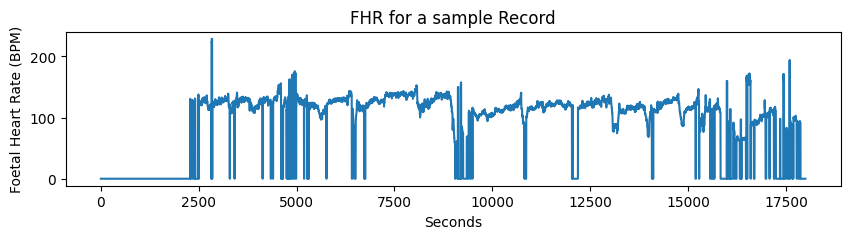

In [9]:
plt.figure(figsize=(10, 2))
plt.plot(signal[:, 0])
plt.title(f'FHR for a sample Record')
plt.xlabel('Seconds')
plt.ylabel('Foetal Heart Rate (BPM)')
plt.show()

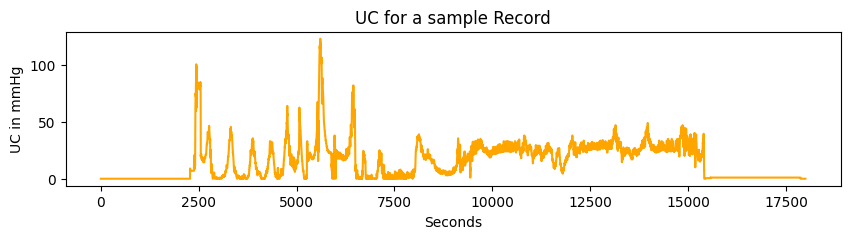

In [10]:
plt.figure(figsize=(10, 2))
plt.plot(signal[:, 1], 'orange')
plt.title(f'UC for a sample Record')
plt.xlabel('Seconds')
plt.ylabel('UC in mmHg')
plt.show()

### Signal preprocessing

In [11]:
sampling_freq = 4 #4hz

def extractLast15Mins(record_name, index):
  record = wfdb.rdrecord(record_name)
  total_duration = record.sig_len / sampling_freq
  start_time = max(0, total_duration - 900)
  start_sample = int(start_time * sampling_freq)  # Multiply by the sampling frequency
  end_sample = record.sig_len
  last_30_minutes = record.p_signal[start_sample:end_sample, index]
  return last_30_minutes

In [12]:
def removeOutliers_FHR (fhr_signal):

  # Define a list to store the modified FHR signal
  modified_fhr_signal = fhr_signal.copy()

  # Specify the range for valid BPM values
  min_bpm = 50
  max_bpm = 200

  # Process the FHR signal
  for i in range(5, len(fhr_signal)):
      if fhr_signal[i] < min_bpm or fhr_signal[i] > max_bpm:
          # Calculate the mean of the last five valid BPM values
          valid_values = [value for value in modified_fhr_signal[i-5:i] if min_bpm <= value <= max_bpm]
          if valid_values:
              mean_value = np.mean(valid_values)
              modified_fhr_signal[i] = mean_value

  return modified_fhr_signal

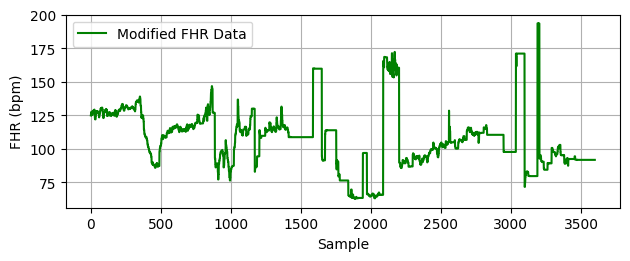

In [13]:
last30 = extractLast15Mins(dataPath + '/1005', 0)
cleaned_fhr_signal = removeOutliers_FHR(last30)

# Modified FHR Data
plt.subplot(2, 1, 2)
plt.plot(cleaned_fhr_signal, label='Modified FHR Data', color='green')
plt.xlabel('Sample')
plt.ylabel('FHR (bpm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
uc_signal30 = extractLast15Mins(dataPath + '/1005', 1)

In [15]:
def getPHvalue(hea_file_path):

  # Initialize a variable to store the pH value
  ph_value = None

  # Open and read the .hea file
  with open(hea_file_path, 'r') as hea_file:
      # Read each line in the file
      for line in hea_file:
          # Check if the line contains pH information
          if line.startswith('#pH'):
              # Extract the pH value from the line
              ph_value = float(line.split()[-1])
              break

  return ph_value

#sample check to PH of a Record
getPHvalue(dataPath + '/1001.hea')

7.14

In [16]:
from sklearn.preprocessing import StandardScaler

def normaliseSignal(signal):
  if signal.ndim == 1:
      signal = signal.reshape(-1, 1)

  # Create a StandardScaler instance
  scaler = StandardScaler()

  # Fit the scaler on the sequence and transform the data
  normalized_signal = scaler.fit_transform(signal)

  # If needed, reshape it back to 1D
  if normalized_signal.ndim == 2:
      normalized_signal = normalized_signal.squeeze()

  return normalized_signal

In [17]:
import pandas as pd

# Create an empty DataFrame
df = pd.DataFrame(columns=["UC_signal", "FHR_signal", "Label"])

# Print the empty DataFrame
print(df)

Empty DataFrame
Columns: [UC_signal, FHR_signal, Label]
Index: []


In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Example UC Sequence as a NumPy array
uc_sequence = np.array(uc_signal30)
fhr_sequence = np.array(cleaned_fhr_signal)

pH = getPHvalue(dataPath + '/1005.hea')


# 0 for normal and  1 for healthy
label = 0 if pH < 7.15 else 1

new_row = {
    "UC_signal": uc_sequence,
    "FHR_signal": fhr_sequence,
    "Label": label
}

# Append the new row to the DataFrame
df = df.append(new_row, ignore_index=True)


### Dataset creation

In [20]:
import wfdb

# Get the list of all available record names
record_list = wfdb.get_record_list(db_name)

print(len(record_list))
# Print the list of record names
for record_name in record_list:
  record_file_path = f"{dataPath}/{record_name}"
  record = wfdb.rdrecord(record_file_path)
  pH = getPHvalue(f"{record_file_path}.hea")

  if pH is None:
    continue

  label = 0 if pH < 7.15 else 1

  fhr_15mins = extractLast15Mins(record_file_path, 0)
  cleaned_fhr_signal = removeOutliers_FHR(fhr_15mins)


  uc_15mins = extractLast15Mins(record_file_path, 1)


  #normalisation
  # fhr_normalised = normaliseSignal(cleaned_fhr_signal)
  # uc_normalised = normaliseSignal(uc_30mins)


  new_row = {
  "UC_signal": cleaned_fhr_signal,
  "FHR_signal": uc_15mins,
  "Label": label
  }

  # Append the new row to the DataFrame
  df = df.append(new_row, ignore_index=True)





552


In [ ]:
df

In [ ]:
df['Label'] = df['Label'].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   UC_signal   553 non-null    object  
 1   FHR_signal  553 non-null    object  
 2   Label       553 non-null    category
dtypes: category(1), object(2)
memory usage: 9.4+ KB


In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from keras.models import Model

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
# Assuming your dataset contains columns for 'UC_signal', 'FHR_signal', and 'Label'

# Split the dataset into features (X) and labels (y)
X = df[['UC_signal', 'FHR_signal']]
y = df['Label']

# Convert string representations of sequences into NumPy arrays
# X['UC_signal'] = X['UC_signal'].apply(lambda x: np.array(eval(x)))
# X['FHR_signal'] = X['FHR_signal'].apply(lambda x: np.array(eval(x)))

# Define 10-fold cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store cross-validation results
test_accuracies = []

# Perform 10-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Normalize the features
    scaler = StandardScaler()
    X_train_UC = np.vstack(X_train['UC_signal'].values)
    X_train_FHR = np.vstack(X_train['FHR_signal'].values)
    X_test_UC = np.vstack(X_test['UC_signal'].values)
    X_test_FHR = np.vstack(X_test['FHR_signal'].values)

    # Define neural network model
    input_UC = Input(shape=(X_train_UC.shape[1],))
    input_FHR = Input(shape=(X_train_FHR.shape[1],))

    # Create separate branches for UC and FHR
    branch_UC = Dense(64, activation='relu')(input_UC)
    branch_FHR = Dense(64, activation='relu')(input_FHR)

    # Concatenate or merge the branches (you can also use 'Add' or other merge methods)
    merged = Concatenate()([branch_UC, branch_FHR])

    # Add more hidden layers if needed
    x = Dense(32, activation='relu')(merged)

    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = Model(inputs=[input_UC, input_FHR], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    y_train = np.array(y_train, dtype='float32')
    y_test = np.array(y_test, dtype='float32')

    # Train the model
    model.fit([X_train_UC, X_train_FHR], y_train, epochs=100, batch_size=32, validation_split=0.2)

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate([X_test_UC, X_test_FHR], y_test)
    test_accuracies.append(test_accuracy)

# Calculate and print the average test accuracy
avg_test_accuracy = np.mean(test_accuracies)
print(f'Average Test Accuracy: {avg_test_accuracy * 100:.2f}%')


Epoch 1/100
13/13 [==============================] - 1s 25ms/step - loss: 48.7079 - accuracy: 0.6524 - val_loss: 14.8161 - val_accuracy: 0.7000
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 15.3375 - accuracy: 0.7531 - val_loss: 31.7372 - val_accuracy: 0.7000
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 14.1067 - accuracy: 0.7607 - val_loss: 10.6294 - val_accuracy: 0.7100
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 5.5375 - accuracy: 0.7506 - val_loss: 3.2899 - val_accuracy: 0.6900
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 2.4317 - accuracy: 0.7909 - val_loss: 6.7545 - val_accuracy: 0.7000
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 2.3141 - accuracy: 0.8035 - val_loss: 3.8623 - val_accuracy: 0.6900
Epoch 7/100
13/13 [==============================] - 0s 12ms/step - loss: 2.0118 - accuracy: 0.8010 - val_loss: 3.1060 - val_accuracy: 0.4700


In [100]:
from sklearn.metrics import accuracy_score
y_pred = model.predict([X_test_UC, X_test_FHR])
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
print(f'Accuracy: {accuracy * 100:.2f}%')

2/2 [==============================] - 0s 13ms/step
Accuracy: 74.55%


In [101]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 2  9]
 [ 5 39]]


In [102]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, (y_pred > 0.5).astype(int))
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.29      0.18      0.22        11
         1.0       0.81      0.89      0.85        44

    accuracy                           0.75        55
   macro avg       0.55      0.53      0.54        55
weighted avg       0.71      0.75      0.72        55



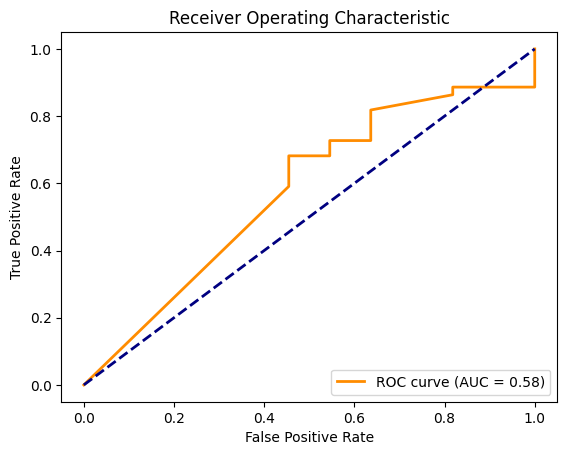

In [103]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [104]:
model.save("Fetal_health_predictor.h5")

**Fetal Health Analysis and Risk Prediction**

**Signal Analysis**

In [87]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    filename = filename.split('.')[0]
    print(f'Uploaded file "{filename}" containing FHR and UC signals')


Saving 1006.hea to 1006.hea
Saving 1006.dat to 1006.dat
Uploaded file "1006" containing FHR and UC signals
Uploaded file "1006" containing FHR and UC signals


In [88]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt


def calculate_baseline_fhr(fhr_signal, time_frame_minutes):
    # Load the WFDB record

    print(len(fhr_signal))
    # Calculate the number of data points in the specified time frame
    sampling_frequency = record.fs  # Sampling frequency in samples per second
    data_points_in_time_frame = int(time_frame_minutes * 60 * sampling_frequency)  # Convert minutes to samples
    print(data_points_in_time_frame)

    # Check if you have enough data points
    if len(fhr_signal) < data_points_in_time_frame:
        raise ValueError("Insufficient data for baseline calculation")

    # Calculate the Baseline FHR as the average over the time frame
    print(fhr_signal[:data_points_in_time_frame])
    baseline_fhr = np.mean(fhr_signal[len(fhr_signal) - data_points_in_time_frame:len(fhr_signal)])

    return baseline_fhr


last30 = extractLast15Mins(f'/content/{filename}', 0)
cleaned_fhr_signal = removeOutliers_FHR(last30)


time_frame_minutes = 10  # Adjust as needed
print(f"{dataPath}/{1005}")
baseline_fhr = calculate_baseline_fhr(cleaned_fhr_signal, time_frame_minutes)
print(f"Baseline FHR: {baseline_fhr} bpm")




/content/FHR_DB/RawData/1005
3600
2400
[143.5        143.5        142.25       ... 109.28825233 150.75
 154.75      ]
Baseline FHR: 120.5593358631709 bpm


In [89]:
import scipy.stats as stats
from scipy.stats import kurtosis

def Calculate_statistical_info(signal):
  signal = np.array(signal)
  signal_SD = np.std(signal)
  skewness = stats.skew(signal)
  signal_kurtosis = kurtosis(signal)
  min_bpm = np.min(signal)
  max_bpm = np.max(signal)
  print(f'SD { signal_SD }, skewnes {skewness}, kurtosis {signal_kurtosis}, min_bpm {min_bpm},  max_bpm {max_bpm}')

  return (min_bpm, max_bpm, signal_SD, skewness, signal_kurtosis)


Calculate_statistical_info(cleaned_fhr_signal)


SD 27.594680046686605, skewnes -0.881802957193012, kurtosis -0.3106847524055838, min_bpm 64.75,  max_bpm 180.75


(64.75, 180.75, 27.594680046686605, -0.881802957193012, -0.3106847524055838)

In [90]:
def naccelartions(signal):


  # Define criteria for acceleration detection
  minimum_increase_bpm = 15  # Minimum increase in bpm to count as an acceleration

  # Initialize a counter for accelerations
  acceleration_count = 0

  # Loop through the FHR signal and detect accelerations
  for i in range(1, len(signal)):
      bpm_increase = signal[i] - signal[i - 1]
      if bpm_increase >= minimum_increase_bpm:
          acceleration_count += 1

  return acceleration_count

In [91]:
def ndecelartions(signal):


  # Define criteria for decelartion detection
  minimum_decrease_bpm = 15  # Minimum increase in bpm to count as an decelartion

  # Initialize a counter for decelartions
  deceleration_count = 0

  # Loop through the FHR signal and detect deceleartions
  for i in range(1, len(signal)):
      bpm_decrease = signal[i - 1] - signal[i]
      if bpm_decrease >= minimum_decrease_bpm:
          deceleration_count += 1

  return deceleration_count

In [92]:
naccelartions(cleaned_fhr_signal)
ndecelartions(cleaned_fhr_signal)

19

In [93]:
uc_signal = extractLast15Mins(f'/content/{filename}', 1)

In [94]:
X_new_UC = np.vstack(uc_signal)
X_new_FHR = np.vstack(cleaned_fhr_signal)

In [95]:
input_shape = model.layers[0].input_shape
print("Input shape:", input_shape)

Input shape: [(None, 3600)]


In [96]:

uc_sig = uc_signal.reshape(-1, 3600)
fhr_sig = cleaned_fhr_signal.reshape(-1, 3600)



### Prediction of Fetal Health Risk

In [70]:
# Make predictions
predictions = model.predict([uc_sig, fhr_sig])
binary_predictions = (predictions > 0.5).astype(int)

if binary_predictions == 1:
  print('Fetal health in risk')
else:
  print('Fetal health is normal')

1/1 [==============================] - 0s 71ms/step
Fetal health in risk


In [71]:
!pip install fpdf2

In [72]:
f_min_bpm, f_max_bpm, f_signal_SD, f_skewness, f_signal_kurtosis  = Calculate_statistical_info(cleaned_fhr_signal)

SD 27.594680046686605, skewnes -0.881802957193012, kurtosis -0.3106847524055838, min_bpm 64.75,  max_bpm 180.75


3600
3600
[143.5  143.5  142.25 ...  83.75  83.75  83.75]


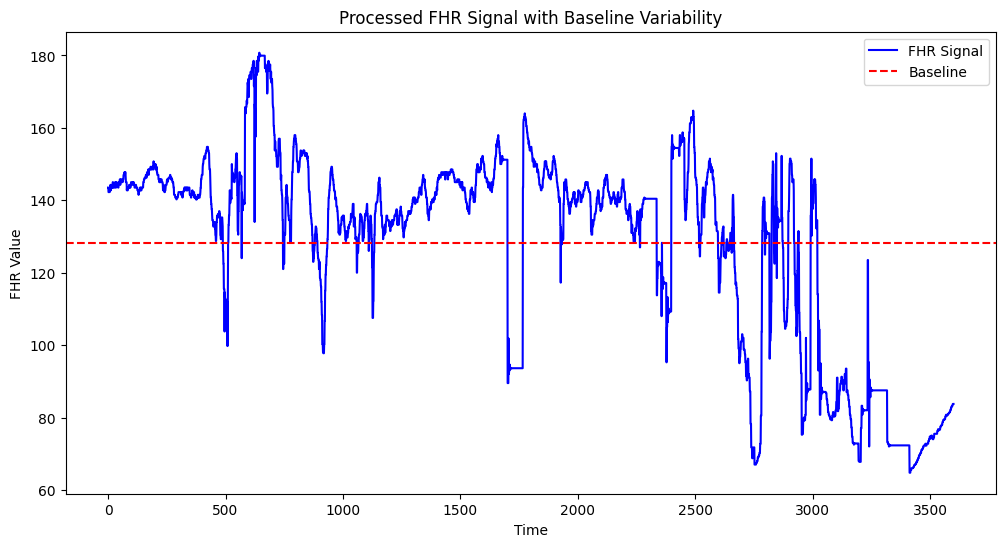

In [73]:
time_frame = 15

baseline = calculate_baseline_fhr(cleaned_fhr_signal, time_frame)

# Create a time array for the x-axis (assuming a fixed sampling rate)
time = time_frame * 60 * 4  # Adjust if needed

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(cleaned_fhr_signal, label='FHR Signal', color='blue')
plt.axhline(baseline, linestyle='--', color='red', label='Baseline')

# Add labels, legend, and title
plt.xlabel('Time')
plt.ylabel('FHR Value')
plt.legend()
plt.title('Processed FHR Signal with Baseline Variability')

# # Show the plot
# plt.grid(True)
# plt.show()

plt.savefig('baseline.png')

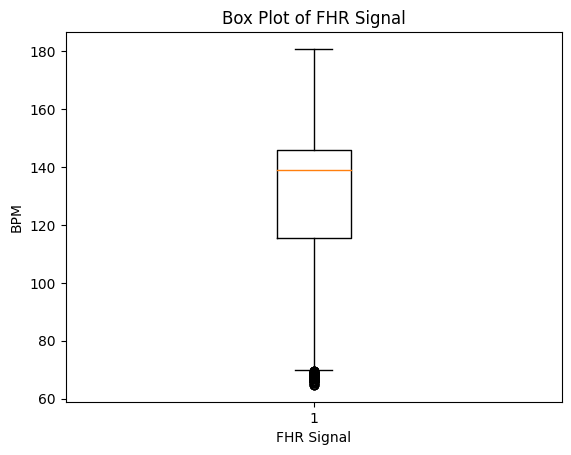

In [74]:
plt.boxplot(cleaned_fhr_signal)

# Add labels and title
plt.xlabel('FHR Signal')
plt.ylabel('BPM')
plt.title('Box Plot of FHR Signal')

plt.savefig('fhr_boxplot.png')

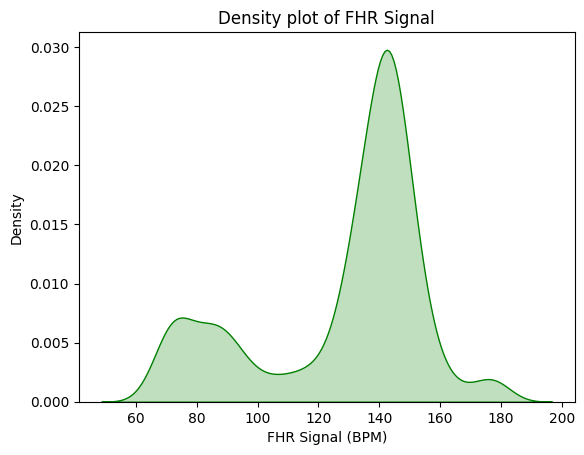

In [75]:
import seaborn as sns
# Create a density plot
sns.kdeplot(cleaned_fhr_signal, shade=True, color='green')

# Add labels and title
plt.xlabel('FHR Signal (BPM)')
plt.ylabel('Density')
plt.title('Density plot of FHR Signal')

plt.savefig('fhr_hist.png')

In [76]:
from fpdf import FPDF

pdf = FPDF('P', 'mm', 'A4')

# pdf.set_auto_page_break(auto=True, margin=15)

pdf.add_page()

pdf.set_font('helvetica', '', 16)

pdf.cell(100, 10, 'Fetal Health Report', ln=True)


pdf.set_font('helvetica', '', 12)
min_bpm, max_bpm, signal_SD, skewness, signal_kurtosis  = Calculate_statistical_info(cleaned_fhr_signal)


pdf.cell(100, 10, f'Min heart beat: {min_bpm:.2f} bpm', ln = True)
pdf.cell(100, 10, f'max heart beat: {max_bpm:.2f} bpm', ln = True)
pdf.cell(100, 10, f'skewness: {skewness:.2f}', ln = True)
pdf.cell(100, 10, f'kurtosis: {signal_kurtosis:.2f}', ln = True)
pdf.cell(100, 10, f'signal_variablity (standard deviation): {signal_SD:.2f}', ln=True)

pdf.image('/content/baseline.png', 10, 125, 100, 50)
pdf.image('/content/fhr_boxplot.png', 110, 125, 100, 50)

time_frame = [15, 10, 5]

for t_f in time_frame:
  baseline = calculate_baseline_fhr(cleaned_fhr_signal, t_f)
  pdf.cell(100, 10, f'Mean fhr for last {t_f} mins: {baseline:.2f} bpm', ln = True)


pdf.image('/content/fhr_hist.png', 10, 175, 100, 50)

nacc = naccelartions(cleaned_fhr_signal)
ndec = ndecelartions(cleaned_fhr_signal)

pdf.cell(100, 10, f'number of accelarations of heart beat: {nacc}', ln = True)
pdf.cell(100, 10, f'number of decelarations of heart beat: {ndec}', ln=True)

pdf.set_text_color(255, 0, 0)  # Red text color (RGB)

if binary_predictions == 1:
  pdf.cell(100, 10, f'Verdict: Fetal Health in Risk', ln=True)
else:
  pdf.cell(100, 10, f'Verdict: Fetus is Healthy', ln=True)


pdf.add_page()
pdf.set_text_color(0, 0, 0)  # Red text color (RGB)
pdf.set_font("Arial", size=9)

# Define the width and height of the cell
cell_width = 0
cell_height = 5


paragraph = """
1. Skewness:
   - Definition: Skewness is a measure of the asymmetry or lack of symmetry in the probability distribution of the FHR values. It quantifies the degree to which the FHR signal is skewed to the left (negatively skewed) or to the right (positively skewed) relative to the mean.
   - Interpretation:
     - Negative Skewness: The FHR values are concentrated on the right side of the distribution, indicating a tendency toward higher heart rates.
     - Positive Skewness: The FHR values are concentrated on the left side of the distribution, indicating a tendency toward lower heart rates.

2. Kurtosis
   - Definition Kurtosis measures the "tailedness" of the probability distribution of the FHR values. It quantifies the degree to which the FHR values are concentrated near the mean (leptokurtic) or spread out more widely (platykurtic).
   - Interpretation
     - Leptokurtic: Higher kurtosis values indicate that the FHR values have heavier tails and are more concentrated around the mean.
     - Platykurtic: Lower kurtosis values indicate that the FHR values have lighter tails and are more spread out.

3. Baseline FHR (Baseline)
   - Definition The baseline FHR represents the average fetal heart.
   - Interpretation A normal baseline FHR typically ranges from 110 to 160 beats per minute (bpm). Deviations from this range may indicate potential issues with fetal well-being.

4. Signal Variability (Signal Variability or FHR Variability):
   - Definition Signal variability measures the variations in the fetal heart rate. It is typically assessed through short-term and long-term variability.
   - Interpretation
     - Adequate Variability: Healthy fetuses typically exhibit moderate and consistent variability, which is reassuring.
     - Reduced Variability: Minimal or absent variability can be concerning and may indicate fetal distress.

5. Number of Accelerations
   - Definition Accelerations are abrupt increases in the FHR, and their presence is often considered a sign of fetal well-being.
   - Interpretation A higher number of accelerations is generally reassuring and indicates that the fetal nervous system is responding to stimuli appropriately.

6. Number of Decelerations
   - Definition Decelerations are abrupt decreases in the FHR, and their presence may require closer evaluation.
   - Interpretation The number and type of decelerations are considered in the context of the overall FHR pattern to assess fetal well-being.
"""


pdf.multi_cell(cell_width, cell_height, paragraph)


pdf.output('Fetal_Health_Report.pdf')



SD 27.594680046686605, skewnes -0.881802957193012, kurtosis -0.3106847524055838, min_bpm 64.75,  max_bpm 180.75
3600
3600
[143.5  143.5  142.25 ...  83.75  83.75  83.75]
3600
2400
[143.5        143.5        142.25       ... 109.28825233 150.75
 154.75      ]
3600
1200
[143.5  143.5  142.25 ... 134.   132.75 134.  ]


##Opentext API

Usage of Core content storage APIs to upload the report in encrypted formated within a secure enviroment.

In [77]:
tenant_id = '6ab2ff57-291a-4f45-b051-4df74bd939db'
css_url = 'css.na-1-dev.api.opentext.com'


In [78]:
import requests

# Define the URL where you want to send the POST request
url = " https://na-1-dev.api.opentext.com/tenants/6ab2ff57-291a-4f45-b051-4df74bd939db/oauth2/token"

data = {
    "client_id": "N2f5j2R21vZtj9fLeGLmZqV4m4y3W3rz",
    "client_secret":  "CrhxC7OG9jYC8Q91",
    "grant_type": "password",
    "username": "ninjadoge000@gmail.com",
    "password": "Opentext@123"
}

response = requests.post(url, data=data)

# Check the response
if response.status_code == 200:  # You can check for the specific status code you expect
    print("POST request was successful!")
    print("Response content:", response.text)
else:
    print("POST request failed with status code:", response.status_code)
    print("Response content:", response.text)


POST request was successful!
Response content: {
  "refresh_token_expires_in" : "2591999",
  "refresh_token_status" : "approved",
  "api_product_list" : "[devx-prod-markup, devx-prod-highlight, devx-prod-publication, devx-prod-decision, devx-prod-workflow, devx-prod-cms, devx-prod-mtm-riskguard, devx-prod-oauth2, devx-prod-capture, devx-prod-admin, devx-prod-viewer, devx-prod-workflow-history, devx-prod-css]",
  "api_product_list_json" : [ "devx-prod-markup", "devx-prod-highlight", "devx-prod-publication", "devx-prod-decision", "devx-prod-workflow", "devx-prod-cms", "devx-prod-mtm-riskguard", "devx-prod-oauth2", "devx-prod-capture", "devx-prod-admin", "devx-prod-viewer", "devx-prod-workflow-history", "devx-prod-css" ],
  "organization_name" : "ot2",
  "token_type" : "Bearer",
  "issued_at" : "1698761954442",
  "client_id" : "N2f5j2R21vZtj9fLeGLmZqV4m4y3W3rz",
  "access_token" : "eyJraWQiOiI1OTc0MmY4NDg3NGYyNzQ1YjIyNTUxYjg5MTY1YWE5Mzc2NWZiODE3IiwidHlwIjoiYXQrand0IiwiYWxnIjoiUlMyNTYifQ.e

In [79]:
import json
data = json.loads(response.text)

In [80]:
access_token = data['access_token']

In [81]:
url = f'https://{css_url}/v2/tenant/{tenant_id}/content'

headers = {
    "Authorization": f"Bearer {access_token}"
}

files = {'pdf_file': ('test.pdf', open('/content/Fetal_Health_Report.pdf', 'rb'), 'application/pdf')}

# Send the POST request with the PDF file
response = requests.post(url, files=files, headers=headers)

# Check the response
if response.status_code >= 200:
    print("PDF file upload was successful!")
    print("Response content:", response.text)
else:
    print("PDF file upload failed with status code:", response.status_code)

PDF file upload was successful!
Response content: {
  "title" : "/content",
  "entries" : [ {
    "objectId" : "",
    "mimeType" : "application/pdf",
    "fileName" : "test.pdf",
    "size" : 113257,
    "createDate" : "2023-10-31T14:19:16.841+0000",
    "lastUpdated" : "2023-10-31T14:19:16.841+0000",
    "providerId" : "c3a09a75-9234-4d77-898a-f246ebbe4f88",
    "tenantId" : "6ab2ff57-291a-4f45-b051-4df74bd939db",
    "subscriptionId" : null,
    "properties" : {
      "MD5" : "A388FB186C237F0FE4021F6A578D4654"
    },
    "renditions" : null,
    "blobId" : "a2f704e3-df2a-4aa4-a157-f41bbef78255",
    "_links" : {
      "self" : {
        "href" : "https://css.na-1-dev.api.opentext.com/v2/content/cj0xYjY0ZjRlZC04ZjQzLTQ1YTctOGE3MC1mNzFkNTk0MWRjNmUmaT1hMmY3MDRlMy1kZjJhLTRhYTQtYTE1Ny1mNDFiYmVmNzgyNTU="
      },
      "download" : {
        "href" : "https://css.na-1-dev.api.opentext.com/v2/content/cj0xYjY0ZjRlZC04ZjQzLTQ1YTctOGE3MC1mNzFkNTk0MWRjNmUmaT1hMmY3MDRlMy1kZjJhLTRhYTQtYTE1Ny1mND

In [82]:
uploadResp = json.loads(response.text)
file_id = uploadResp['entries'][0]['id']
file_id

'cj0xYjY0ZjRlZC04ZjQzLTQ1YTctOGE3MC1mNzFkNTk0MWRjNmUmaT1hMmY3MDRlMy1kZjJhLTRhYTQtYTE1Ny1mNDFiYmVmNzgyNTU='

In [83]:
url = f'https://{css_url}/v2/content/{file_id}/download'

headers = {
    "Authorization": f"Bearer {access_token}"
}

response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Save the downloaded file to your Colab workspace

    filename = 'Fetal_health_report.pdf'
    with open(filename, 'wb') as file:
        file.write(response.content)

    print(f"File '{filename}' downloaded successfully.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File 'Fetal_health_report.pdf' downloaded successfully.


**View report in your local storage or use POSTMAN API with below access token and file ID**



```



In [85]:
print(f'File ID is {file_id}')
print(f'Bearer Access token is {access_token}')

File ID is cj0xYjY0ZjRlZC04ZjQzLTQ1YTctOGE3MC1mNzFkNTk0MWRjNmUmaT1hMmY3MDRlMy1kZjJhLTRhYTQtYTE1Ny1mNDFiYmVmNzgyNTU=
Bearer Access token is eyJraWQiOiI1OTc0MmY4NDg3NGYyNzQ1YjIyNTUxYjg5MTY1YWE5Mzc2NWZiODE3IiwidHlwIjoiYXQrand0IiwiYWxnIjoiUlMyNTYifQ.eyJ0ZW5hbnRfaWQiOiI2YWIyZmY1Ny0yOTFhLTRmNDUtYjA1MS00ZGY3NGJkOTM5ZGIiLCJzdWIiOiJiNjEyM2Y2Ny00NmMyLTQ1NDItOTI4Ni0yZmQwYzMyMjA5MDciLCJjb250cmFjdF9pZCI6IjdjYmVkM2IzLWIwNzItNGIyZC1hZjlkLTIwYWQ2YmVkZjAwZSIsImFtciI6WyJwd2QiXSwiaXNzIjoiaHR0cHM6Ly9jb21tb25hdXRoLmRldnhwcm9kLm90Mi5vcGVudGV4dC5jb20iLCJjbGllbnRfaWQiOiJOMmY1ajJSMjF2WnRqOWZMZUdMbVpxVjRtNHkzVzNyeiIsImF1ZCI6WyJvdDIiXSwiYXV0aF90aW1lIjoxNjk4NzYxOTU0LCJzY29wZSI6WyJvdDI6Y3JlYXRlX3B1YmxpY2F0aW9ucyIsIm90MjpkZWxldGVfcHVibGljYXRpb25zIiwib3QyOnZpZXdfcHVibGljYXRpb25zIiwib3QyOnNlYXJjaF9wdWJsaWNhdGlvbnMiLCJvdDI6cmVhZHdyaXRlIiwib3QyOnNlYXJjaCJdLCJuYW1lIjoibmluamFkb2dlMDAwQGdtYWlsLmNvbSIsImV4cCI6MTY5ODc2Mjg1NCwiaWF0IjoxNjk4NzYxOTU0LCJqdGkiOiI5ZGMzMTZlNi01OWVjLTRiZmItYjljOC00ODkyNTA3Y2ViMzgiLCJlbWFpbCI6Im5pbm

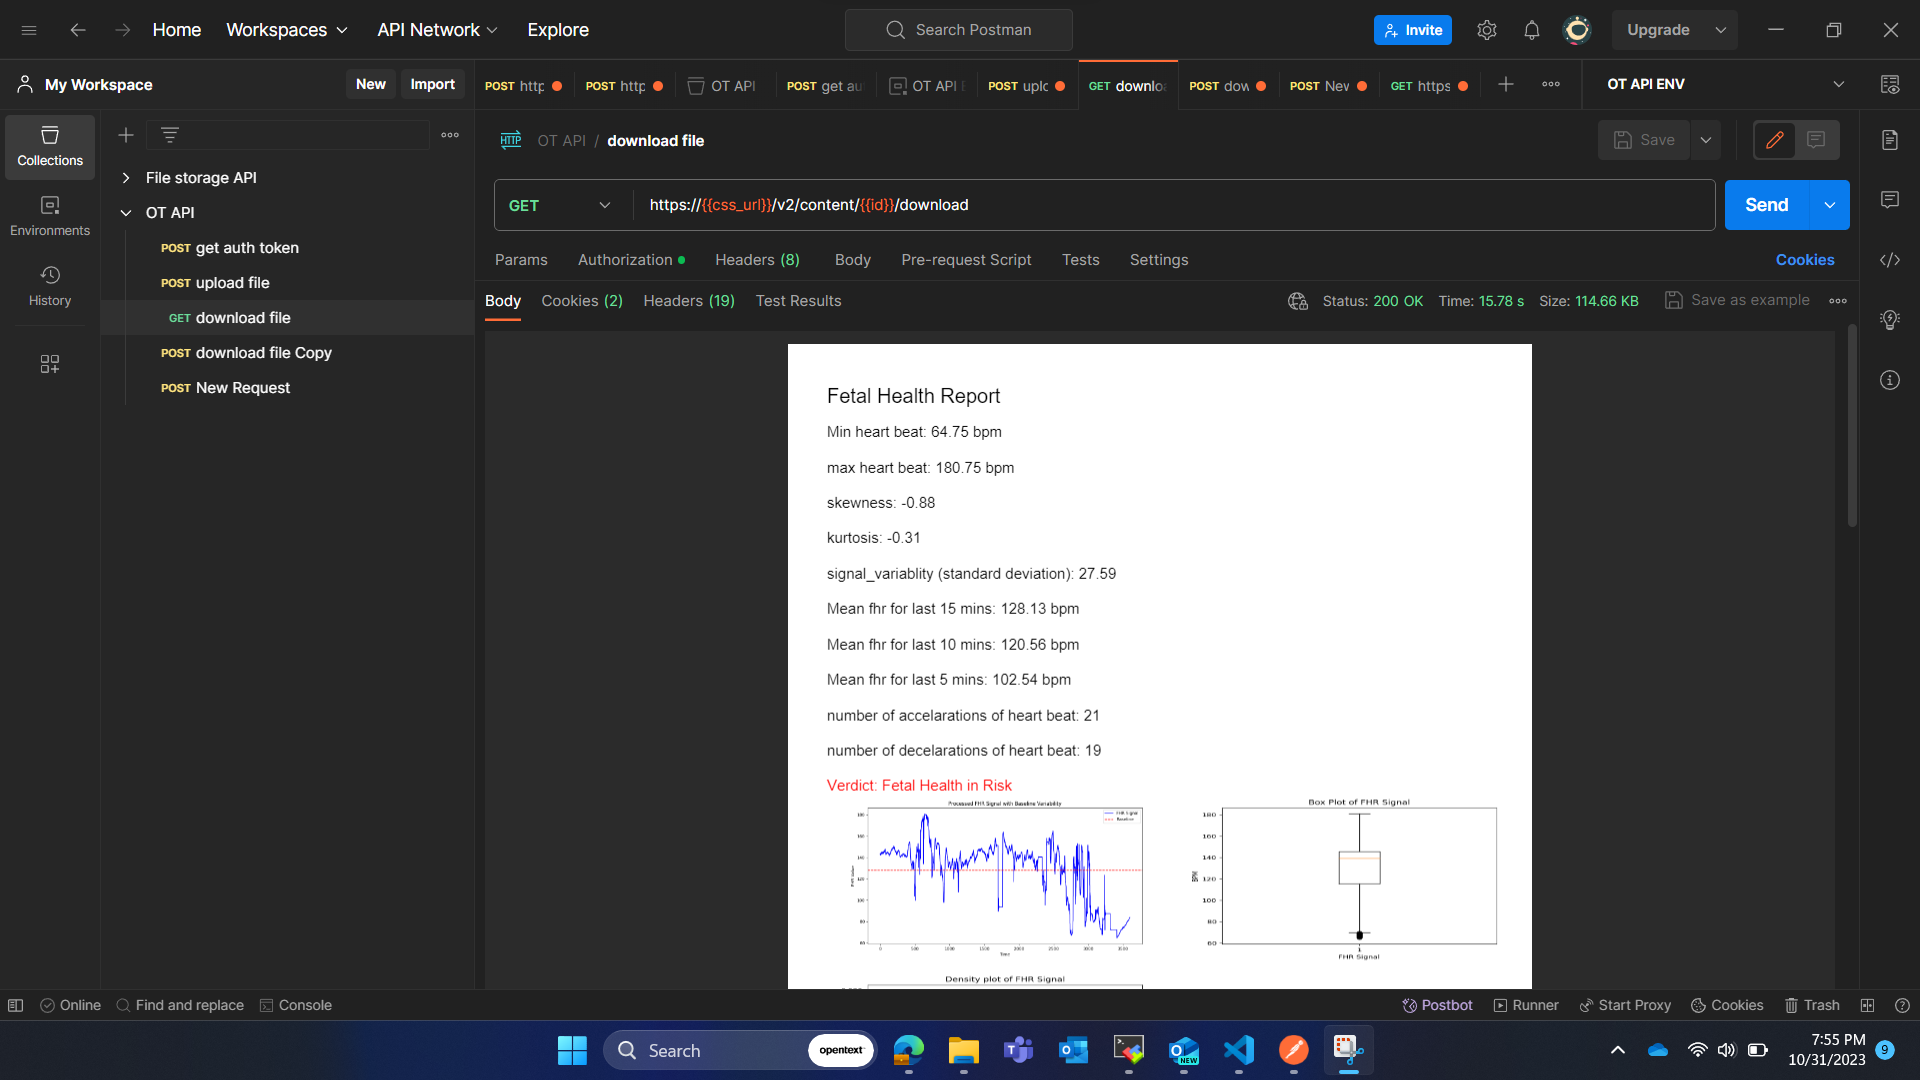

**Sample Report**

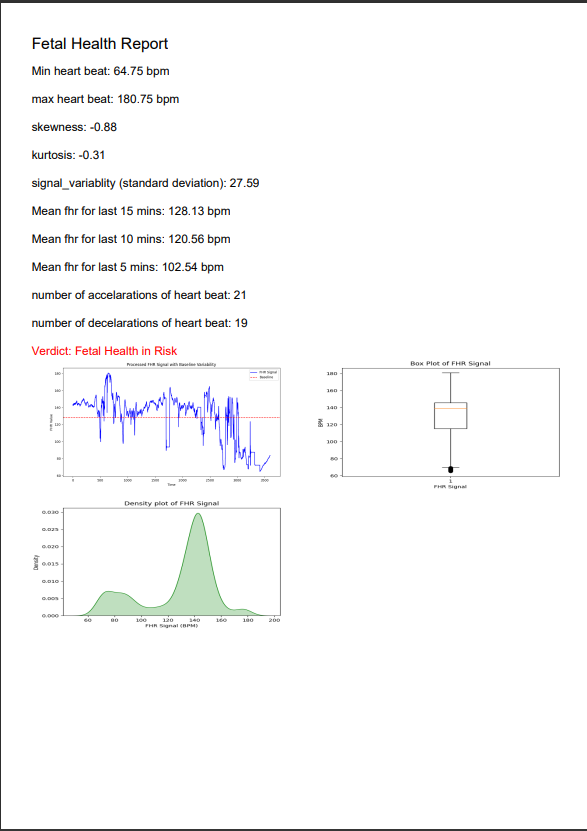

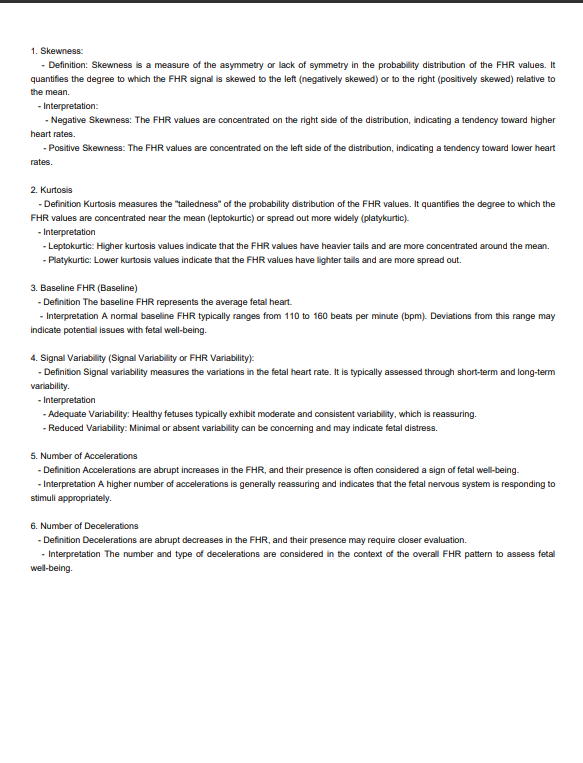